In [1]:
import pathlib
import sys
import math
module_dir = pathlib.Path("").parent.resolve()
root_dir = module_dir.parent
source_dir = root_dir.joinpath("source")
model_dir = root_dir.joinpath("model")
asvlite_wrapper_dir = root_dir.joinpath("dependency", "ASVLite", "wrapper", "cython")
sys.path.insert(0, str(source_dir))
sys.path.insert(0, str(asvlite_wrapper_dir))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from autosklearn.regression import AutoSklearnRegressor

In [4]:
from joblib import dump

## Load training data

In [5]:
training_data_file = "../results/glider_thrust/tuning/tuning_factors_for_training.csv"
cols_to_use = ["Timestamp(UTC)",
               "distance(m)",
               "delta_T(s)",
               "delta_T_simulated(s)",
               "speed(knots)",
               "speed_simulated(knots)",
               "simulated_wave_height(m)", 
               "current(knots)", 
               "relative_current_direction", 
               "tuning_factor",
               "error_msg"]
df = pd.read_csv(training_data_file, usecols = cols_to_use)
df["relative_current_direction(abs)"] = df["relative_current_direction"].abs()

# Find the proportion of training data for which the tuning factor was computed.
count_rows = len(df)
count_rows_with_tuning = len(df["tuning_factor"].dropna()) 
count_rows_no_tuning = count_rows - count_rows_with_tuning
print("Number of voyage segments for which tuning factor was not computed = {}.".format(count_rows_no_tuning))
print("Tuning factor was computed for {:.2f}% of segments.".format(100*count_rows_with_tuning/count_rows))

df = df[df["tuning_factor"].notna()]
df.reset_index(drop=True, inplace=True)

Number of voyage segments for which tuning factor was not computed = 1622.
Tuning factor was computed for 94.70% of segments.


In [6]:
# Group segments based on simuated wave heights
for i in range(len(df)):
    df.loc[i, "tuning_group"] = int(math.ceil(df.loc[i, "simulated_wave_height(m)"]))

## Explore the training data

<AxesSubplot: xlabel='simulated_wave_height(m)', ylabel='tuning_factor'>

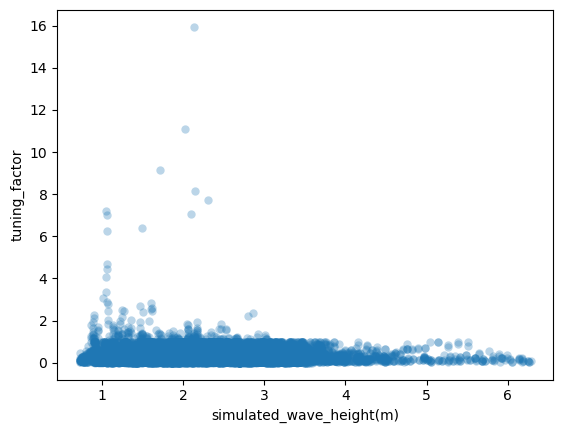

In [7]:
# Scatter plot all tuning factors
sns.scatterplot(data=df, x="simulated_wave_height(m)", y="tuning_factor", alpha=0.3, linewidth=0)

<AxesSubplot: xlabel='tuning_group', ylabel='tuning_factor'>

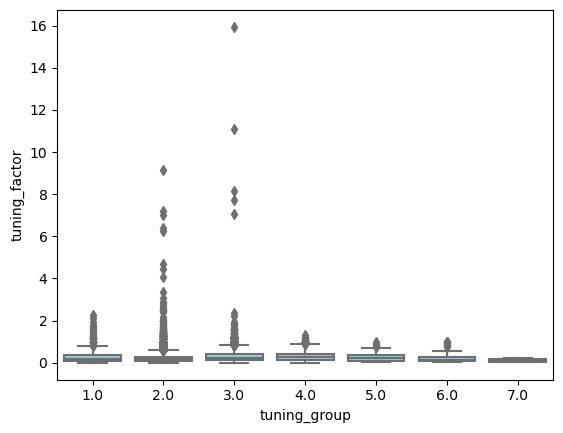

In [8]:
sns.boxplot(data=df, y="tuning_factor", x="tuning_group", color='skyblue')

In [9]:
# Remove outliers and replot
q_1  = df["tuning_factor"].quantile(0.01)
q_99 = df["tuning_factor"].quantile(0.99)
df = df[(df["tuning_factor"] < q_99) & (df["tuning_factor"] > q_1)]

<AxesSubplot: xlabel='simulated_wave_height(m)', ylabel='tuning_factor'>

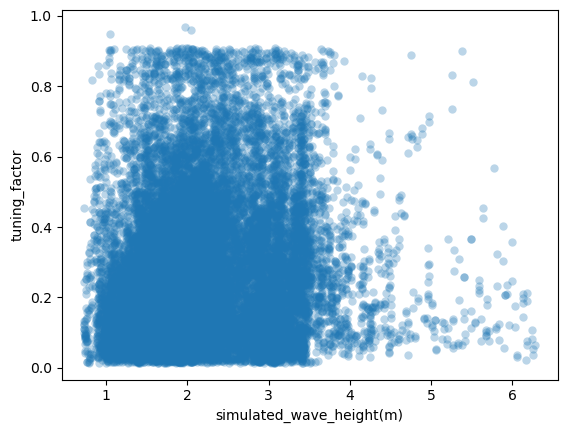

In [10]:
sns.scatterplot(data=df, x="simulated_wave_height(m)", y="tuning_factor", alpha=0.3, linewidth=0)

<AxesSubplot: xlabel='tuning_group', ylabel='tuning_factor'>

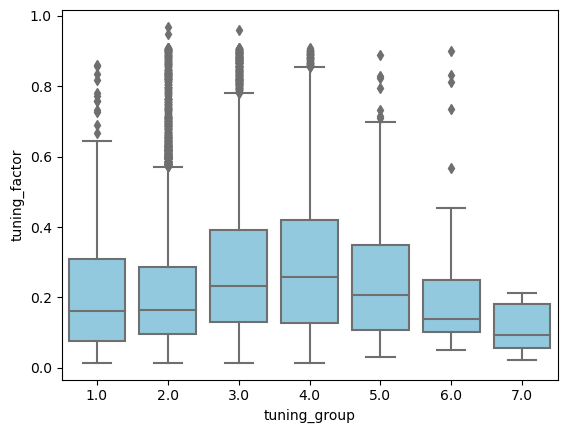

In [11]:
sns.boxplot(data=df, y="tuning_factor", x="tuning_group", color='skyblue')

## Thrust tuning factor models

In [12]:
df["simulated_wave_height(m)"].describe()

count    27864.000000
mean         2.110348
std          0.698339
min          0.726029
25%          1.653266
50%          1.976719
75%          2.427000
max          6.282036
Name: simulated_wave_height(m), dtype: float64

In [13]:
df["current(knots)"].describe()

count    27864.000000
mean         0.340347
std          0.201017
min          0.008918
25%          0.181627
50%          0.308333
75%          0.469314
max          1.187907
Name: current(knots), dtype: float64

In [14]:
X = df[["simulated_wave_height(m)", "current(knots)", "relative_current_direction(abs)"]].values
y = df["tuning_factor"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Model 1 - Linear regression based only on wave height

In [15]:
model_1 = LinearRegression().fit(np.array([row[0] for row in X_train]).reshape(-1, 1), np.array(y_train))
# Test model performance
y_hat = model_1.predict(np.array([row[0] for row in X_test]).reshape(-1, 1))
model_1_mse = mean_squared_error(y_test, y_hat)
model_1_r2  = r2_score(y_test, y_hat)
print("mse = {}".format(model_1_mse))
print("r2 = {}".format(model_1_r2))

mse = 0.03406820273475034
r2 = 0.02589095820604037


<AxesSubplot: >

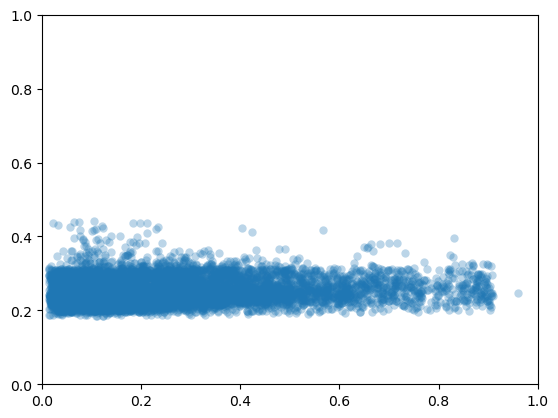

In [16]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y_test, y=y_hat, alpha=0.3, linewidth=0)

### Model 2 - Linear regression using wave height, current speed and direction

In [17]:
model_2 = LinearRegression().fit(X_train, y_train)
# Test model performance
y_hat = model_2.predict(X_test)
model_2_mse = mean_squared_error(y_test, y_hat)
model_2_r2  = r2_score(y_test, y_hat)
print("mse = {}".format(model_2_mse))
print("r2 = {}".format(model_2_r2))

mse = 0.03395928212861105
r2 = 0.02900531525340333


<AxesSubplot: >

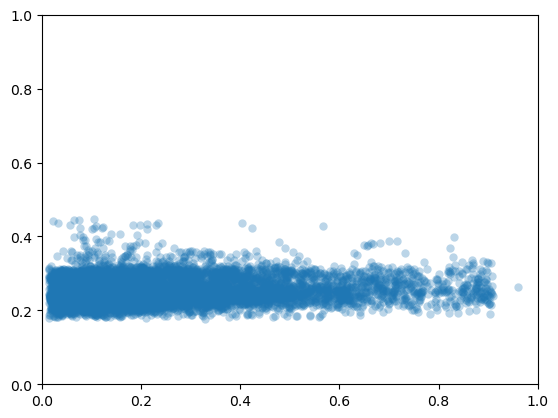

In [18]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y_test, y=y_hat, alpha=0.3, linewidth=0)

### Model 3 - XGBoost

In [19]:
model_3 = XGBRegressor().fit(X_train, y_train)
# Test model performance
y_hat = model_3.predict(X_test)
model_3_mse = mean_squared_error(y_test, y_hat)
model_3_r2  = r2_score(y_test, y_hat)
print("mse = {}".format(model_3_mse))
print("r2 = {}".format(model_3_r2))

mse = 0.020486450823453264
r2 = 0.414232763120271


<AxesSubplot: >

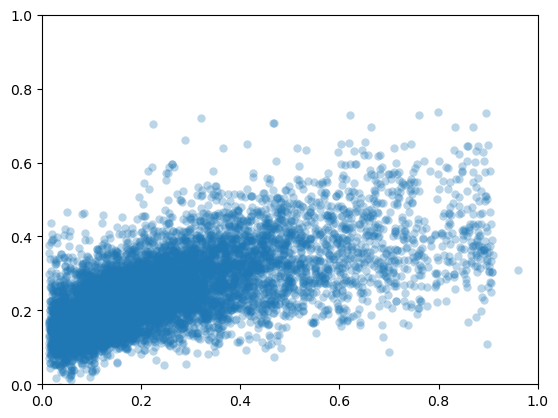

In [20]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y_test, y=y_hat, alpha=0.3, linewidth=0)

### Model 4 - AutoML

In [21]:
model_4 = AutoSklearnRegressor().fit(X_train, y_train)
# Test model performance
y_hat = model_4.predict(X_test)
model_4_mse = mean_squared_error(y_test, y_hat)
model_4_r2  = r2_score(y_test, y_hat)
print("mse = {}".format(model_4_mse))
print("r2 = {}".format(model_4_r2))
print(model_4.sprint_statistics())
print(model_4.leaderboard())

[WARNING] [2023-03-11 06:40:24,033:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2023-03-11 06:40:38,943:Client-EnsembleBuilder] No runs were available to build an ensemble from
mse = 0.017132991693779916
r2 = 0.5101179169375949
auto-sklearn results:
  Dataset name: 888d5553-bfd7-11ed-b40b-4851b716dee7
  Metric: r2
  Best validation score: 0.517750
  Number of target algorithm runs: 142
  Number of successful target algorithm runs: 103
  Number of crashed target algorithm runs: 19
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 14

          rank  ensemble_weight               type      cost   duration
model_id                                                               
140          1             0.34        extra_trees  0.482250   8.633009
20           2             0.30        extra_trees  0.486113   7.562999
41           3             0.16  gradient_boosting  0.530353

<AxesSubplot: >

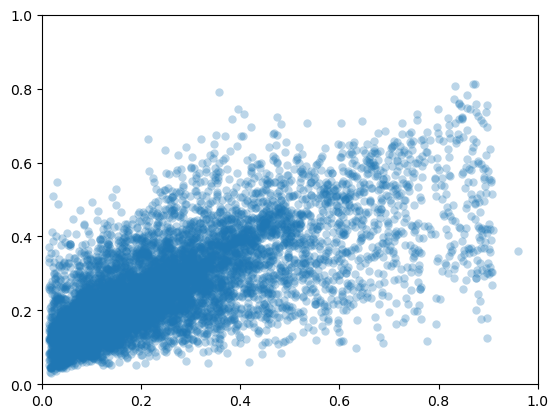

In [22]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y_test, y=y_hat, alpha=0.3, linewidth=0)

### Model 5 - Linear regression with uniform population 

In [23]:
# Count number of segments in each wave group
print("wave height range - count instances")
for group_name, group in df.groupby("tuning_group"):
    print("({}, {}) - {}".format(group_name-1, group_name, len(group)))

wave height range - count instances
(0.0, 1.0) - 454
(1.0, 2.0) - 13935
(2.0, 3.0) - 9951
(3.0, 4.0) - 3184
(4.0, 5.0) - 244
(5.0, 6.0) - 78
(6.0, 7.0) - 18


In [24]:
# Create a new training data with a max of 200 instances from each group
max_count = 200
df_new = pd.DataFrame()
for group_name, group in df.groupby("tuning_group"):
    if len(group) > max_count:
        df_new = pd.concat([df_new, group.sample(max_count)])
    else:
        df_new = pd.concat([df_new, group])

In [25]:
# Count number of segments in each wave group of the new training data
print("wave height range - count instances")
for group_name, group in df_new.groupby("tuning_group"):
    print("({}, {}) - {}".format(group_name-1, group_name, len(group)))

wave height range - count instances
(0.0, 1.0) - 200
(1.0, 2.0) - 200
(2.0, 3.0) - 200
(3.0, 4.0) - 200
(4.0, 5.0) - 200
(5.0, 6.0) - 78
(6.0, 7.0) - 18


In [26]:
X_train = df_new[["simulated_wave_height(m)", "current(knots)", "relative_current_direction(abs)"]].values
y_train = df_new["tuning_factor"].values

In [27]:
model_5 = LinearRegression().fit(np.array([row[0] for row in X_train]).reshape(-1, 1), np.array(y_train))
# Test model performance
y_hat = model_5.predict(np.array([row[0] for row in X_test]).reshape(-1, 1))
model_5_mse = mean_squared_error(y_test, y_hat)
model_5_r2  = r2_score(y_test, y_hat)
print("mse = {}".format(model_5_mse))
print("r2 = {}".format(model_5_r2))

mse = 0.03474374275119836
r2 = 0.006575303569394841


<AxesSubplot: >

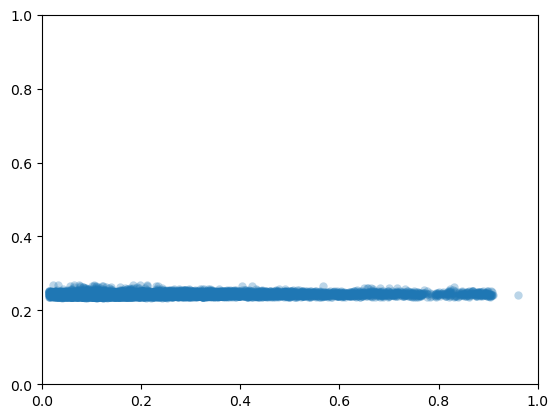

In [28]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y_test, y=y_hat, alpha=0.3, linewidth=0)

### Model 6 - Linear regression with uniform population and taking wave and current

In [29]:
model_6 = LinearRegression().fit(X_train, y_train)
# Test model performance
y_hat = model_6.predict(X_test)
model_6_mse = mean_squared_error(y_test, y_hat)
model_6_r2  = r2_score(y_test, y_hat)
print("mse = {}".format(model_6_mse))
print("r2 = {}".format(model_6_r2))

mse = 0.034635558871711075
r2 = 0.009668595458180773


<AxesSubplot: >

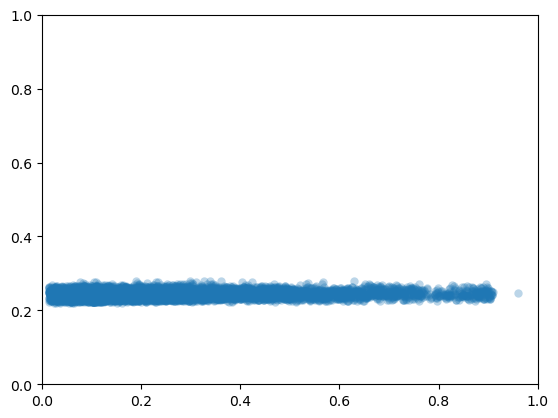

In [30]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y_test, y=y_hat, alpha=0.3, linewidth=0)

## Save models to file

In [31]:
file_name = model_dir.joinpath("thrust_tuning_lin_reg_1.joblib")
dump(model_1, str(file_name)) 

['/home/toby/Projects/storm_tracking/model/thrust_tuning_lin_reg_1.joblib']

In [32]:
file_name = model_dir.joinpath("thrust_tuning_lin_reg_2.joblib")
dump(model_2, str(file_name)) 

['/home/toby/Projects/storm_tracking/model/thrust_tuning_lin_reg_2.joblib']

In [33]:
file_name = model_dir.joinpath("thrust_tuning_xgboost.joblib")
dump(model_3, str(file_name)) 

['/home/toby/Projects/storm_tracking/model/thrust_tuning_xgboost.joblib']

In [34]:
file_name = model_dir.joinpath("thrust_tuning_automl.joblib")
dump(model_4, str(file_name)) 

['/home/toby/Projects/storm_tracking/model/thrust_tuning_automl.joblib']

In [35]:
file_name = model_dir.joinpath("thrust_tuning_lin_reg_3.joblib")
dump(model_5, str(file_name)) 

['/home/toby/Projects/storm_tracking/model/thrust_tuning_lin_reg_3.joblib']

In [36]:
file_name = model_dir.joinpath("thrust_tuning_lin_reg_4.joblib")
dump(model_6, str(file_name)) 

['/home/toby/Projects/storm_tracking/model/thrust_tuning_lin_reg_4.joblib']